# predicting implied volatility in option trading using NN(i only used LSTM)

https://www.investopedia.com/terms/i/iv.asp

https://en.wikipedia.org/wiki/Implied_volatility


code here used part of yours, and add some code by me

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

options_path = "./dataset/ndx_option_raw.csv"
options = pd.read_csv(options_path)


options['date']  = pd.to_datetime(options['date'])
options['exdate'] = pd.to_datetime(options['exdate'])
options['mid_price'] = (options['best_bid'] + options['best_offer']) / 2
#expire date
options['days_to_expiry'] = (options['exdate'] - options['date']).dt.days
# 5.3: encode call/put flag
options['cp_flag_encoded'] = options['cp_flag'].map({'C': 1, 'P': 0})

# divide strike price by 1000( strike prices recorded  strike price * 1000)
options['strike_price'] = (options['strike_price'])/1000

# Step 8: Drop rows with missing critical values
required_cols = [
    'strike_price','cp_flag_encoded',
   'days_to_expiry','impl_volatility','delta','gamma','vega','theta','mid_price'
]
df = options.dropna(subset=required_cols)

# Step 9: Select features and target
features = [
    'strike_price','cp_flag_encoded',
   'days_to_expiry','mid_price','delta','gamma','vega','theta'
]
X = df[features]
y= df['impl_volatility']
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


this code is for toy case MLP, referenced by yours and class note. 

/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4619/4619 ━━━━━━━━━━━━━━━━━━━━ 1s 286us/step


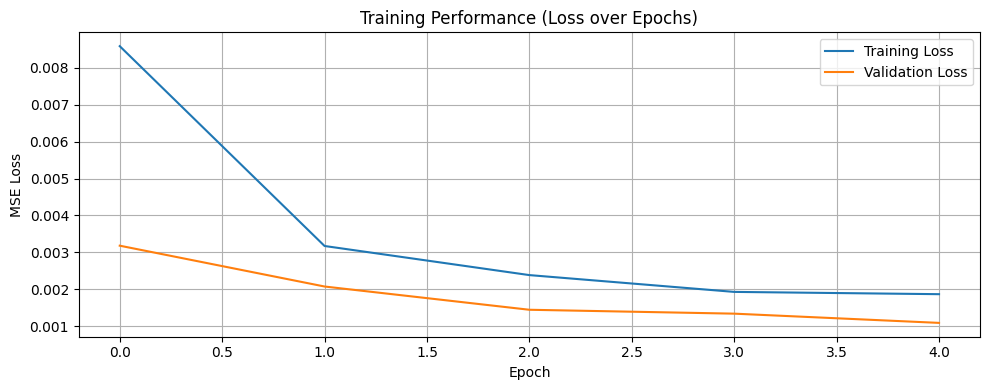

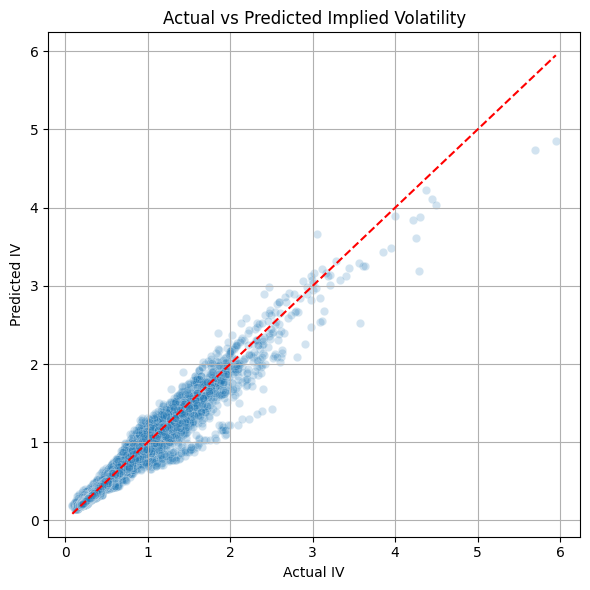

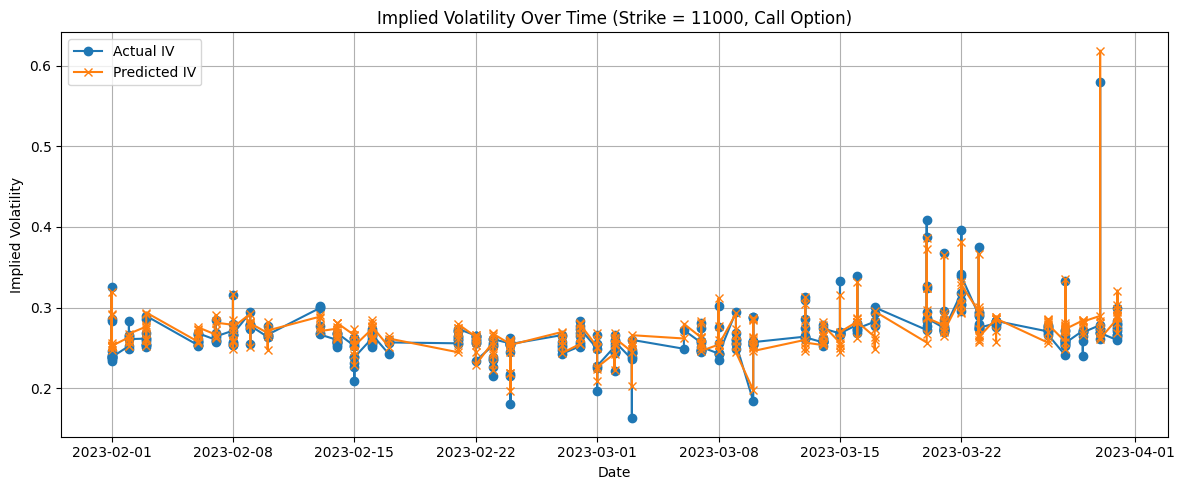

(0.9702660723849131, 0.000996776465163869)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model training(not tuned, i will use more dense layer due to large dataset)
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  
])
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train,
                    validation_split=0.2,
                    epochs=5,
                    batch_size=512,
                    callbacks=[early_stop],
                    verbose=0)

y_pred = model.predict(X_test_scaled).flatten()

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training Performance (Loss over Epochs)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Actual vs Predicted Implied Volatility")
plt.xlabel("Actual IV")
plt.ylabel("Predicted IV")
plt.grid(True)
plt.tight_layout()
plt.show()


# application on result(time series plot)
#test data
df_test = X_test.copy()
df_test['impl_volatility'] = y_test.values
df_test['predicted_iv'] = y_pred
df_test['date'] = df.loc[y_test.index, 'date']
df_test['cp_flag'] = df.loc[y_test.index, 'cp_flag']
df_test['strike_price'] = df.loc[y_test.index, 'strike_price']



subset = df_test[(df_test['strike_price'] == 12000) & (df_test['cp_flag'] == 'C')].copy()
subset['date'] = pd.to_datetime(subset['date'])
subset = subset.sort_values('date')

#time series plot for strike price 12000 call option
subset = df_test[(df_test['strike_price'] == 12000) & (df_test['cp_flag'] == 'C')].copy()
subset['date'] = pd.to_datetime(subset['date'])
subset = subset.sort_values('date')


plt.figure(figsize=(12, 5))
plt.plot(subset['date'], subset['impl_volatility'], label='Actual IV', marker='o')
plt.plot(subset['date'], subset['predicted_iv'], label='Predicted IV', marker='x')
plt.title("Implied Volatility Over Time (Strike = 11000, Call Option)")
plt.xlabel("Date")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
r2, mse

In [3]:
df = df.sort_values(by='date') #by date
grouped = df.groupby(['strike_price', 'cp_flag_encoded']) # group by strike price,call or put

In [4]:
from tensorflow.keras.layers import LSTM, Dense
# Create sequences
sequence_length = 3
X_seq, y_seq = [], []
target = 'impl_volatility'
for _, group in grouped:
    group = group.sort_values('date')
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(group[features])
    y_vals = group[target].values

    for i in range(len(group) - sequence_length):
        X_seq.append(X_scaled[i:i+sequence_length])
        y_seq.append(y_vals[i+sequence_length])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(256, activation='relu', input_shape=(sequence_length, len(features))),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = model.fit(X_train, y_train, epochs=5, batch_size=512, validation_split=0.1)


y_pred = model.predict(X_test).flatten()


print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


Epoch 1/5


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 2/5
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 3/5
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 4/5
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 5/5
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0243 - val_mse: 0.0243
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
R²: 0.2873085281251583
MSE: 0.02426590854707489


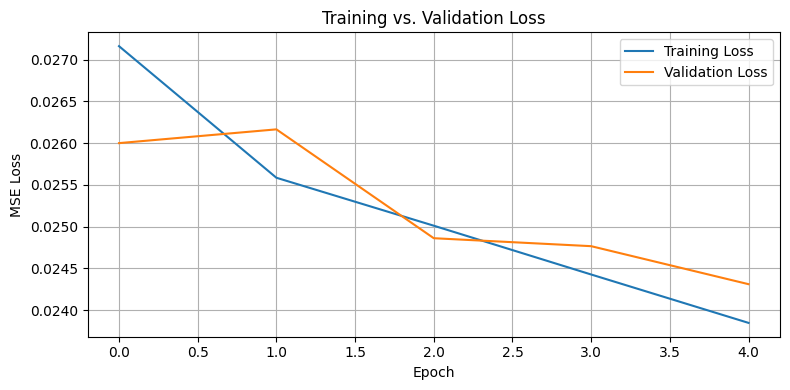

R²: 0.2873085281251583
MSE: 0.02426590854707489


In [5]:
#plots are used the code we normally use for HW,lab for this class
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


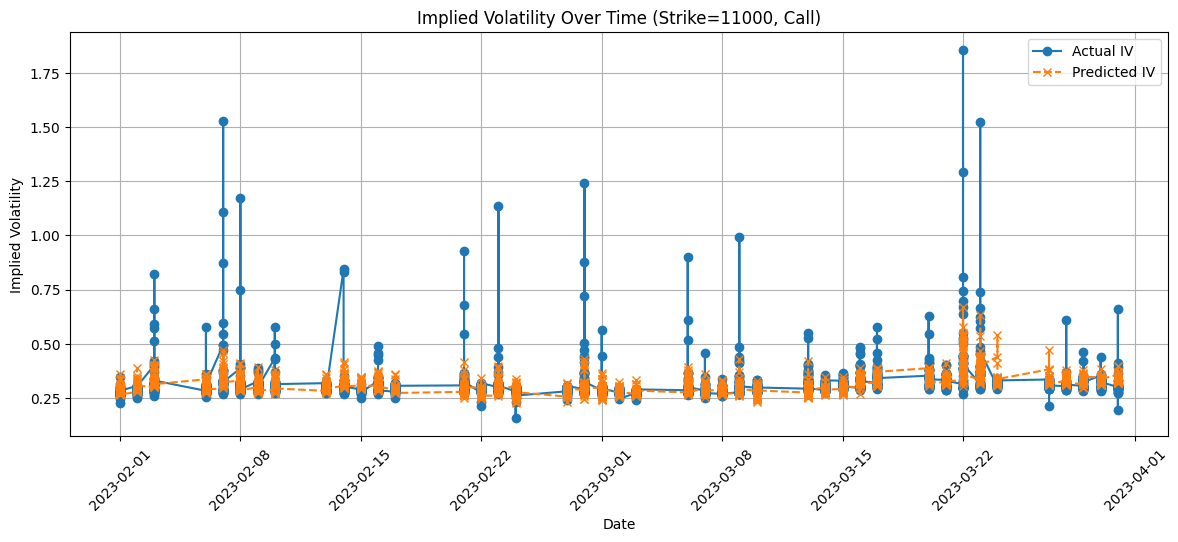

In [6]:
## this one is reference by chatGPT due to different concept application. i will remake it- this is used to show  demo

from sklearn.model_selection import train_test_split


# Step 2: Extract one example group for visualization
example_strike = 11000
example_cp_flag = 1  # 1 = Call, 0 = Put

example_df = df[(df['strike_price'] == example_strike) & (df['cp_flag_encoded'] == example_cp_flag)]
example_df = example_df.sort_values('date')

# Step 3: Build sequences for this group again
scaler = StandardScaler()
X_scaled = scaler.fit_transform(example_df[features])
y_true = example_df['impl_volatility'].values

X_seq_plot = []
dates_seq = []

for i in range(len(example_df) - sequence_length):
    X_seq_plot.append(X_scaled[i:i+sequence_length])
    dates_seq.append(example_df['date'].iloc[i + sequence_length])  # prediction is for T

X_seq_plot = np.array(X_seq_plot)
y_true_plot = y_true[sequence_length:]  # shift target

# Step 4: Predict on the sequences
y_pred_plot = model.predict(X_seq_plot).flatten()

# Step 5: Plot
plt.figure(figsize=(12, 5))
plt.plot(dates_seq, y_true_plot, label='Actual IV', marker='o')
plt.plot(dates_seq, y_pred_plot, label='Predicted IV', linestyle='--', marker='x')
plt.title(f"Implied Volatility Over Time (Strike={example_strike}, Call)")
plt.xlabel("Date")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


# Simple RNN with Group K Fold


--- Fold 1 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4440/4440 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step
Fold 1 — MSE: 0.0012, R²: 0.9691

--- Fold 2 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4887/4887 ━━━━━━━━━━━━━━━━━━━━ 2s 326us/step
Fold 2 — MSE: 0.0012, R²: 0.9624

--- Fold 3 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4439/4439 ━━━━━━━━━━━━━━━━━━━━ 1s 280us/step
Fold 3 — MSE: 0.0016, R²: 0.9444

--- Fold 4 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4887/4887 ━━━━━━━━━━━━━━━━━━━━ 1s 292us/step
Fold 4 — MSE: 0.0006, R²: 0.9853

--- Fold 5 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4441/4441 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step
Fold 5 — MSE: 0.0004, R²: 0.9836

Cross‑Validation Summary
MSE scores: [0.0012283450620793352, 0.0012331924349645897, 0.0015951297536837819, 0.0005799630516493858, 0.0004246109554375547]
R² scores : [0.969086858489206, 0.9623828871560812, 0.9443753818040876, 0.9853418220723159, 0.9835625178647371]
Average MSE: 0.0010
Average R² : 0.9689


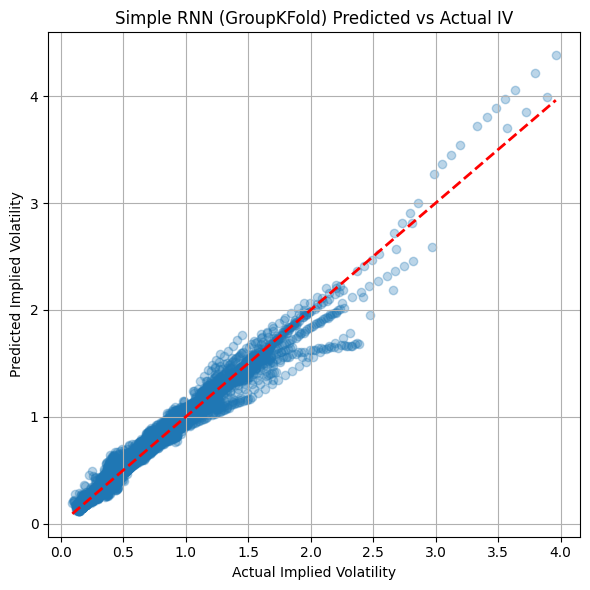

In [ ]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# Read raw option quotes
options_path = "./dataset/ndx_option_raw.csv"
df = pd.read_csv(options_path)

# Parse date fields
df['date'] = pd.to_datetime(df['date'])
df['exdate'] = pd.to_datetime(df['exdate'])

# Create basic option features
df['mid_price'] = (df['best_bid'] + df['best_offer']) / 2
df['days_to_expiry'] = (df['exdate'] - df['date']).dt.days
df['cp_flag_encoded'] = df['cp_flag'].map({'C': 1, 'P': 0})
df['strike_price'] = df['strike_price'] / 1000  # raw strike prices are scaled

# Keep only complete records
required_cols = [
    'strike_price', 'cp_flag_encoded', 'days_to_expiry',
    'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 'mid_price'
]
df = df.dropna(subset=required_cols)

# Prepare inputs and targets
features = [
    'strike_price', 'cp_flag_encoded', 'days_to_expiry',
    'mid_price', 'delta', 'gamma', 'vega', 'theta'
]
X = df[features].values
y = df['impl_volatility'].values
groups = df['date'].values  # group data by trading day

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for RNN input (timesteps = 1)
X_rnn = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Set up grouped cross-validation
gkf = GroupKFold(n_splits=5)
mse_scores = []
r2_scores = []

for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_rnn, y, groups), 1):
    print(f"\n--- Fold {fold_idx} ---")
    
    X_train, X_test = X_rnn[train_idx], X_rnn[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Define a simple RNN model for regression
    model = Sequential([
        SimpleRNN(64, input_shape=(1, X_train.shape[2])),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train quietly
    model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=0)

    # Make predictions
    y_pred = model.predict(X_test).flatten()

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"Fold {fold_idx} — MSE: {mse:.4f}, R²: {r2:.4f}")

# Display overall validation performance
print("\nCross-Validation Results:")
print("MSE scores:", mse_scores)
print("R² scores :", r2_scores)
print(f"Average MSE: {np.mean(mse_scores):.4f}")
print(f"Average R² : {np.mean(r2_scores):.4f}")

# Visualize prediction performance on the final fold
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Implied Volatility")
plt.ylabel("Predicted Implied Volatility")
plt.title("Predicted vs Actual (Simple RNN)")
plt.grid(True)
plt.tight_layout()
plt.show()


--- Fold 1 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4440/4440 ━━━━━━━━━━━━━━━━━━━━ 2s 326us/step
Fold 1 — MSE: 0.0006, R²: 0.9857

--- Fold 2 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4887/4887 ━━━━━━━━━━━━━━━━━━━━ 2s 303us/step
Fold 2 — MSE: 0.0008, R²: 0.9742

--- Fold 3 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4439/4439 ━━━━━━━━━━━━━━━━━━━━ 1s 301us/step
Fold 3 — MSE: 0.0007, R²: 0.9769

--- Fold 4 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4887/4887 ━━━━━━━━━━━━━━━━━━━━ 2s 303us/step
Fold 4 — MSE: 0.0008, R²: 0.9798

--- Fold 5 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4441/4441 ━━━━━━━━━━━━━━━━━━━━ 1s 302us/step
Fold 5 — MSE: 0.0003, R²: 0.9877

Cross‑Validation Summary
MSE scores: [0.0006 0.0008 0.0007 0.0008 0.0003]
R² scores : [0.9857 0.9742 0.9769 0.9798 0.9877]
Average MSE: 0.0006
Average R² : 0.9808


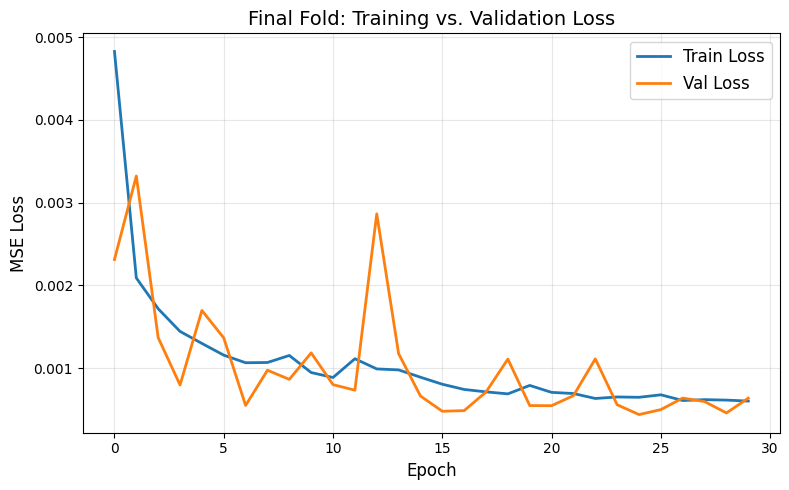

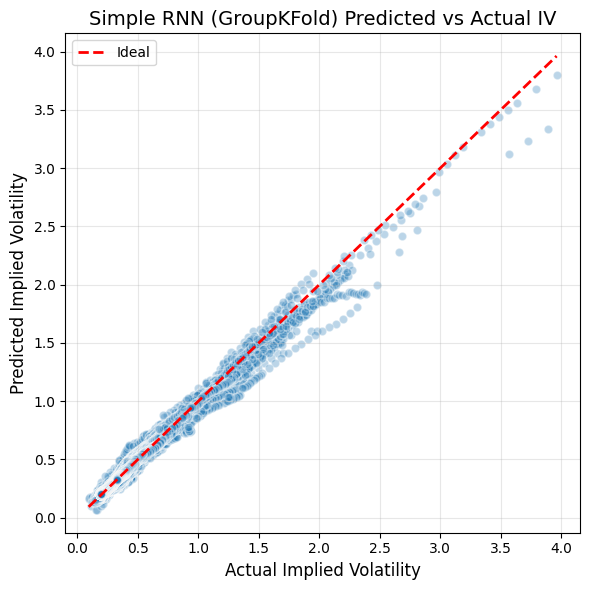

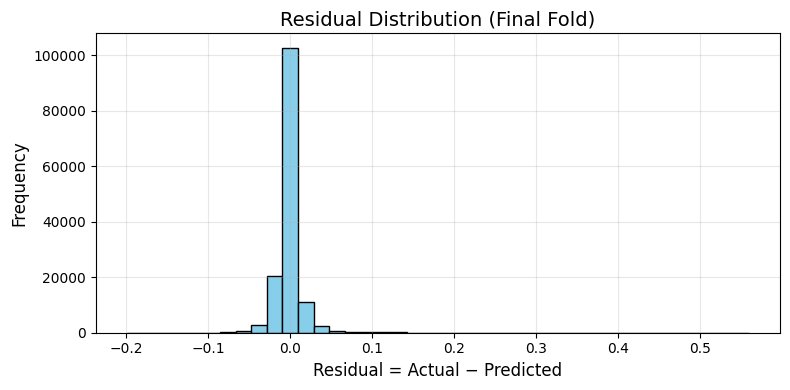

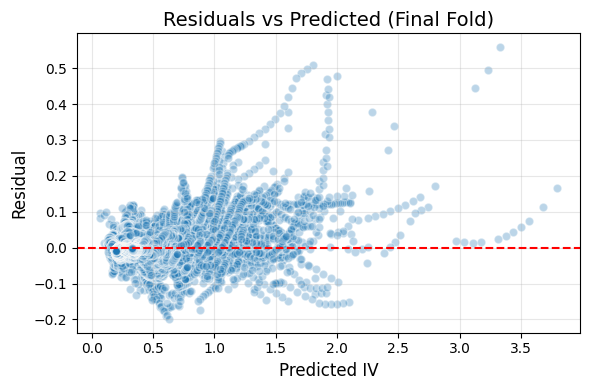

In [ ]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt

# Read raw option quotes
options_path = "./dataset/ndx_option_raw.csv"
df = pd.read_csv(options_path)

# Parse dates and create features
df['date'] = pd.to_datetime(df['date'])
df['exdate'] = pd.to_datetime(df['exdate'])
df['mid_price'] = (df['best_bid'] + df['best_offer']) / 2
df['days_to_expiry'] = (df['exdate'] - df['date']).dt.days
df['cp_flag_encoded'] = df['cp_flag'].map({'C': 1, 'P': 0})
df['strike_price'] = df['strike_price'] / 1000

# Drop rows with missing critical fields
required = [
    'strike_price', 'cp_flag_encoded', 'days_to_expiry',
    'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 'mid_price'
]
df = df.dropna(subset=required)

# Set up features, target, and groups
features = [
    'strike_price', 'cp_flag_encoded', 'days_to_expiry',
    'mid_price', 'delta', 'gamma', 'vega', 'theta'
]
X = df[features].values
y = df['impl_volatility'].values
groups = df['date'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for RNN input
X_rnn = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Grouped cross-validation setup
gkf = GroupKFold(n_splits=5)
mse_list, r2_list = [], []
histories = []

for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_rnn, y, groups), 1):
    print(f"\n--- Fold {fold_idx} ---")
    
    X_train, X_test = X_rnn[train_idx], X_rnn[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Build RNN model
    model = Sequential([
        SimpleRNN(64, input_shape=(1, X_train.shape[2])),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=64,
        validation_split=0.1,
        verbose=0
    )
    histories.append(history)

    # Evaluate
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_list.append(mse)
    r2_list.append(r2)

    print(f"Fold {fold_idx} — MSE: {mse:.4f}, R²: {r2:.4f}")

# Summarize overall results
print("\nCross-Validation Summary")
print("MSE scores:", np.round(mse_list, 4))
print("R² scores :", np.round(r2_list, 4))
print(f"Average MSE: {np.mean(mse_list):.4f}")
print(f"Average R² : {np.mean(r2_list):.4f}")

# Plot training vs validation loss on the final fold
final_history = histories[-1]
plt.figure(figsize=(8, 5))
plt.plot(final_history.history['loss'], label='Train Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss (Final Fold)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='w')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Implied Volatility")
plt.ylabel("Predicted Implied Volatility")
plt.title("Predicted vs Actual (Final Fold)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot residuals distribution
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=40, color='skyblue', edgecolor='black')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals vs Predicted values
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolors='w')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Implied Volatility")
plt.ylabel("Residual")
plt.title("Residuals vs Predictions")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Compare RNN model to simple baselines
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupKFold

# Assume X_scaled, y, groups are already loaded

gkf = GroupKFold(n_splits=5)

mse_lr, r2_lr = [], []
mse_rf, r2_rf = [], []

for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_scaled, y, groups), 1):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Linear Regression
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    preds_lr = model_lr.predict(X_test)
    mse_lr.append(mean_squared_error(y_test, preds_lr))
    r2_lr.append(r2_score(y_test, preds_lr))

    # Random Forest
    model_rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    )
    model_rf.fit(X_train, y_train)
    preds_rf = model_rf.predict(X_test)
    mse_rf.append(mean_squared_error(y_test, preds_rf))
    r2_rf.append(r2_score(y_test, preds_rf))

    print(f"Fold {fold_idx}: LR MSE = {mse_lr[-1]:.4f}, LR R² = {r2_lr[-1]:.4f} | "
          f"RF MSE = {mse_rf[-1]:.4f}, RF R² = {r2_rf[-1]:.4f}")

# Final summary
print("\n[Linear Regression] Avg MSE:", round(np.mean(mse_lr), 4), "| Avg R²:", round(np.mean(r2_lr), 4))
print("[Random Forest]    Avg MSE:", round(np.mean(mse_rf), 4), "| Avg R²:", round(np.mean(r2_rf), 4))

Fold 1 — LR MSE: 0.0224, LR R²: 0.4372 | RF MSE: 0.0099, RF R²: 0.7512
Fold 2 — LR MSE: 0.0200, LR R²: 0.3893 | RF MSE: 0.0105, RF R²: 0.6794
Fold 3 — LR MSE: 0.0194, LR R²: 0.3251 | RF MSE: 0.0048, RF R²: 0.8319
Fold 4 — LR MSE: 0.0210, LR R²: 0.4683 | RF MSE: 0.0060, RF R²: 0.8477
Fold 5 — LR MSE: 0.0181, LR R²: 0.3008 | RF MSE: 0.0079, RF R²: 0.6932

Linear Regression (5‑Fold) — Avg MSE: 0.0202, Avg R²: 0.3841
Random Forest (5‑Fold) — Avg MSE: 0.0078, Avg R²: 0.7607


# LSTM (Group K Fold)


--- LSTM Fold 1 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4440/4440 ━━━━━━━━━━━━━━━━━━━━ 2s 422us/step
Fold 1 — MSE: 0.0015, R²: 0.9632

--- LSTM Fold 2 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4887/4887 ━━━━━━━━━━━━━━━━━━━━ 2s 484us/step
Fold 2 — MSE: 0.0012, R²: 0.9620

--- LSTM Fold 3 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4439/4439 ━━━━━━━━━━━━━━━━━━━━ 2s 389us/step
Fold 3 — MSE: 0.0012, R²: 0.9571

--- LSTM Fold 4 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4887/4887 ━━━━━━━━━━━━━━━━━━━━ 2s 328us/step
Fold 4 — MSE: 0.0011, R²: 0.9725

--- LSTM Fold 5 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4441/4441 ━━━━━━━━━━━━━━━━━━━━ 2s 462us/step
Fold 5 — MSE: 0.0008, R²: 0.9678

LSTM Cross‑Val Summary
MSE: [0.0015 0.0012 0.0012 0.0011 0.0008]
R² : [0.9632 0.962  0.9571 0.9725 0.9678]
Avg MSE: 0.0012, Avg R²: 0.9645

Baseline Summary
LR Avg MSE: 0.0202, Avg R²: 0.3841
RF Avg MSE: 0.0008, Avg R²: 0.9755


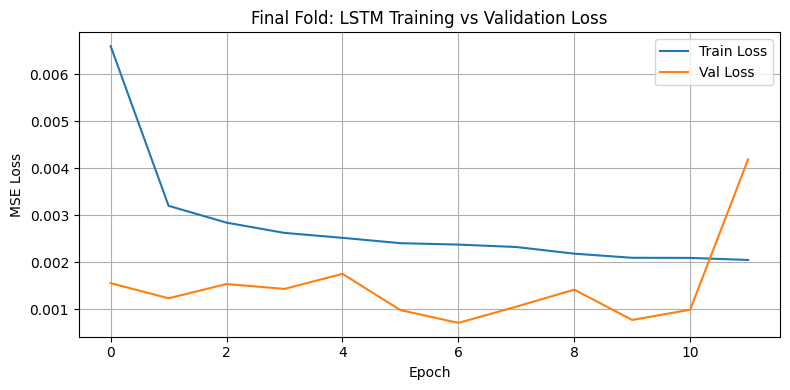

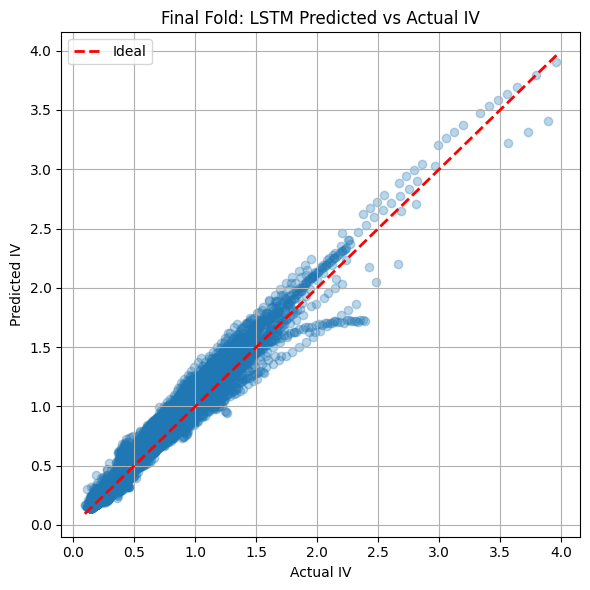

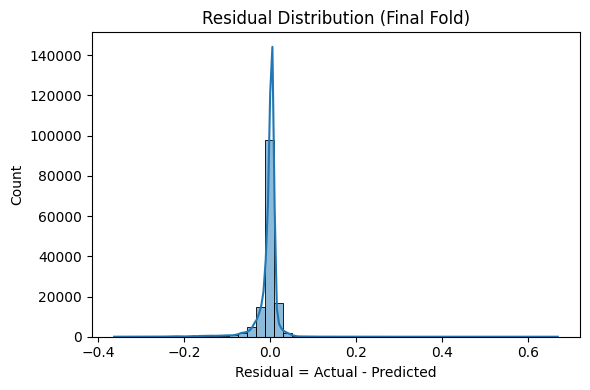

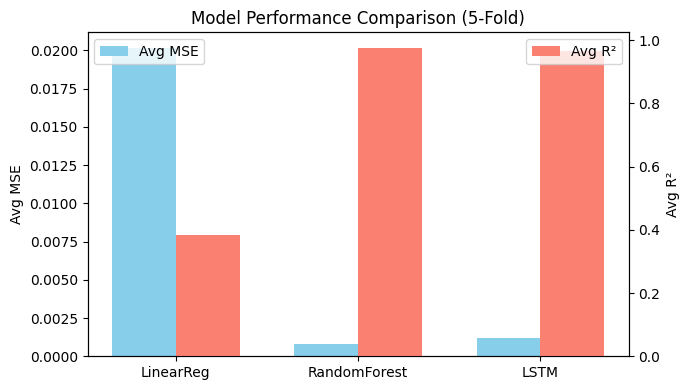

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess data
df = pd.read_csv("./dataset/ndx_option_raw.csv")
df['date'] = pd.to_datetime(df['date'])
df['exdate'] = pd.to_datetime(df['exdate'])
df['mid_price'] = (df['best_bid'] + df['best_offer']) / 2
df['days_to_expiry'] = (df['exdate'] - df['date']).dt.days
df['cp_flag_encoded'] = df['cp_flag'].map({'C': 1, 'P': 0})
df['strike_price'] = df['strike_price'] / 1000

required_cols = [
    'strike_price', 'cp_flag_encoded', 'days_to_expiry',
    'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 'mid_price'
]
df = df.dropna(subset=required_cols)

features = [
    'strike_price', 'cp_flag_encoded', 'days_to_expiry',
    'mid_price', 'delta', 'gamma', 'vega', 'theta'
]
X = df[features].values
y = df['impl_volatility'].values
groups = df['date'].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# LSTM cross-validation
gkf = GroupKFold(n_splits=5)
mse_lstm, r2_lstm = [], []
final_y_true, final_y_pred, last_history = None, None, None

for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_lstm, y, groups), 1):
    print(f"\nFold {fold_idx}")

    X_train, X_test = X_lstm[train_idx], X_lstm[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = Sequential([
        LSTM(64, input_shape=(1, X_lstm.shape[2])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=64,
        validation_split=0.1,
        callbacks=[es],
        verbose=0
    )

    preds = model.predict(X_test).flatten()
    mse_lstm.append(mean_squared_error(y_test, preds))
    r2_lstm.append(r2_score(y_test, preds))

    if fold_idx == 5:
        final_y_true = y_test
        final_y_pred = preds
        last_history = history

# Print LSTM results
print("\nLSTM Cross-Validation Results")
print(f"Avg MSE: {np.mean(mse_lstm):.4f}")
print(f"Avg R² : {np.mean(r2_lstm):.4f}")

# Baseline models: Linear Regression and Random Forest
mse_lr, r2_lr, mse_rf, r2_rf = [], [], [], []

for train_idx, test_idx in gkf.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    lr_model = LinearRegression().fit(X_train, y_train)
    preds_lr = lr_model.predict(X_test)
    mse_lr.append(mean_squared_error(y_test, preds_lr))
    r2_lr.append(r2_score(y_test, preds_lr))

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
    preds_rf = rf_model.predict(X_test)
    mse_rf.append(mean_squared_error(y_test, preds_rf))
    r2_rf.append(r2_score(y_test, preds_rf))

# Print baseline results
print("\nBaseline Models")
print(f"Linear Regression Avg MSE: {np.mean(mse_lr):.4f}, Avg R²: {np.mean(r2_lr):.4f}")
print(f"Random Forest Avg MSE: {np.mean(mse_rf):.4f}, Avg R²: {np.mean(r2_rf):.4f}")

# --- Plots ---

# Train vs Val Loss
plt.figure(figsize=(8, 5))
plt.plot(last_history.history['loss'], label='Train Loss')
plt.plot(last_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss (Final Fold)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Predicted vs Actual (Final Fold)
plt.figure(figsize=(6,6))
plt.scatter(final_y_true, final_y_pred, alpha=0.3)
plt.plot([final_y_true.min(), final_y_true.max()],
         [final_y_true.min(), final_y_true.max()],
         'r--', linewidth=2)
plt.xlabel('Actual IV')
plt.ylabel('Predicted IV')
plt.title('LSTM Prediction vs Actual')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals histogram
residuals = final_y_true - final_y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=40, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Compare models by MSE
models = ['LinearReg', 'RandomForest', 'LSTM']
avg_mse = [np.mean(mse_lr), np.mean(mse_rf), np.mean(mse_lstm)]

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=avg_mse, palette='Set2')
plt.ylabel('Average MSE')
plt.title('Model Performance (MSE)')
plt.tight_layout()
plt.show()

# GRU (Group K Fold)


--- GRU Fold 1 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4440/4440 ━━━━━━━━━━━━━━━━━━━━ 2s 490us/step
Fold 1 — MSE: 0.0012, R²: 0.9694

--- GRU Fold 2 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4887/4887 ━━━━━━━━━━━━━━━━━━━━ 2s 415us/step
Fold 2 — MSE: 0.0012, R²: 0.9646

--- GRU Fold 3 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4439/4439 ━━━━━━━━━━━━━━━━━━━━ 2s 457us/step
Fold 3 — MSE: 0.0011, R²: 0.9605

--- GRU Fold 4 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4887/4887 ━━━━━━━━━━━━━━━━━━━━ 3s 553us/step
Fold 4 — MSE: 0.0011, R²: 0.9720

--- GRU Fold 5 ---


/opt/anaconda3/envs/env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4441/4441 ━━━━━━━━━━━━━━━━━━━━ 2s 384us/step
Fold 5 — MSE: 0.0005, R²: 0.9822


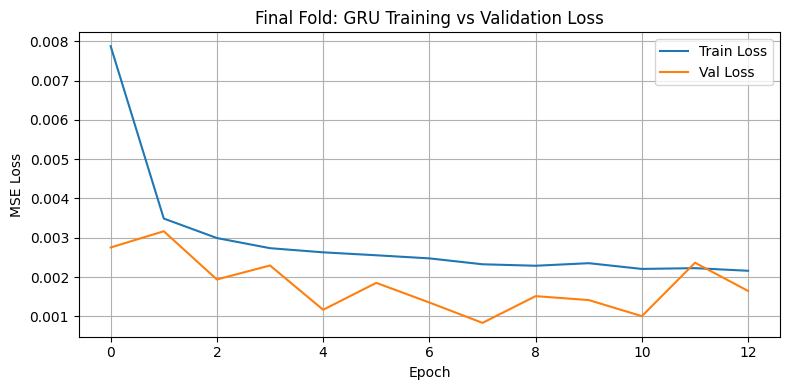

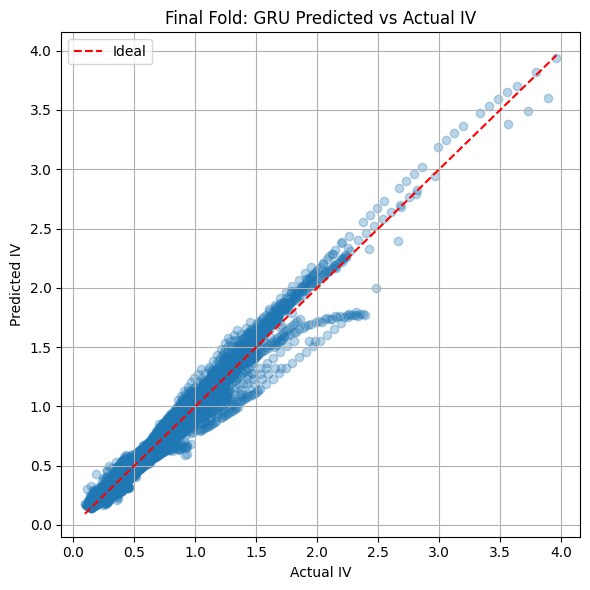

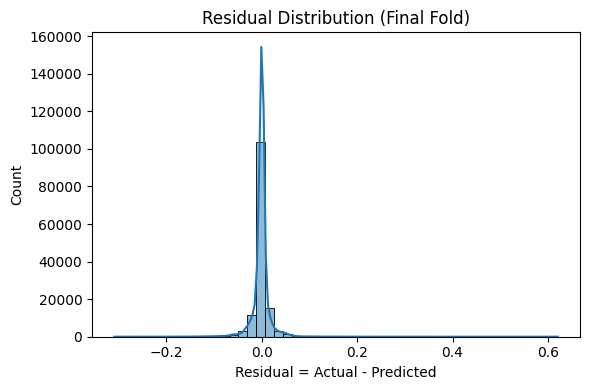

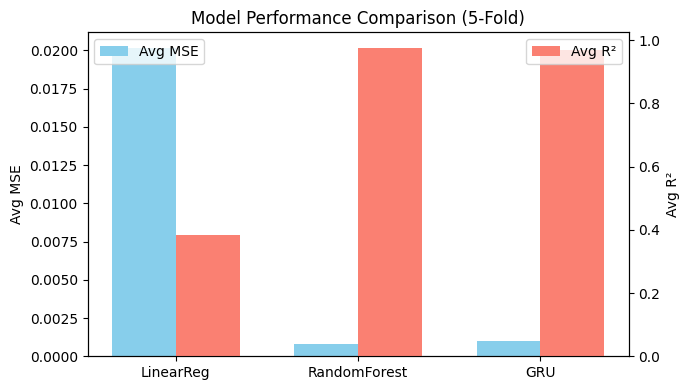


GRU Cross-Validation Summary
MSE: [0.0012 0.0012 0.0011 0.0011 0.0005]
R²: [0.9694 0.9646 0.9605 0.972  0.9822]
Avg MSE: 0.0010, Avg R²: 0.9697


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess the dataset
df = pd.read_csv("./dataset/ndx_option_raw.csv")
df['date'] = pd.to_datetime(df['date'])
df['exdate'] = pd.to_datetime(df['exdate'])
df['mid_price'] = (df['best_bid'] + df['best_offer']) / 2
df['days_to_expiry'] = (df['exdate'] - df['date']).dt.days
df['cp_flag_encoded'] = df['cp_flag'].map({'C': 1, 'P': 0})
df['strike_price'] = df['strike_price'] / 1000

# Drop rows with missing values in critical columns
required_cols = [
    'strike_price', 'cp_flag_encoded', 'days_to_expiry',
    'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 'mid_price'
]
df = df.dropna(subset=required_cols)

features = [
    'strike_price', 'cp_flag_encoded', 'days_to_expiry',
    'mid_price', 'delta', 'gamma', 'vega', 'theta'
]
X = df[features].values
y = df['impl_volatility'].values
groups = df['date'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for GRU input (samples, timesteps=1, features)
X_gru = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Set up GroupKFold
gkf = GroupKFold(n_splits=5)

# Containers for GRU metrics
mse_gru, r2_gru = [], []
final_y_true, final_y_pred = None, None
final_history = None

# Train GRU across folds
for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_gru, y, groups), start=1):
    print(f"\nFold {fold_idx}")

    X_train, X_test = X_gru[train_idx], X_gru[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = Sequential([
        GRU(64, input_shape=(1, X_gru.shape[2])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=64,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0
    )

    preds = model.predict(X_test).flatten()
    mse_gru.append(mean_squared_error(y_test, preds))
    r2_gru.append(r2_score(y_test, preds))

    if fold_idx == 5:
        final_y_true = y_test
        final_y_pred = preds
        final_history = history

# Show GRU results
print("\nGRU Cross-Validation Results")
print(f"Avg MSE: {np.mean(mse_gru):.4f}")
print(f"Avg R² : {np.mean(r2_gru):.4f}")

# Baselines: Linear Regression and Random Forest
mse_lr, r2_lr, mse_rf, r2_rf = [], [], [], []

for train_idx, test_idx in gkf.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    lr = LinearRegression().fit(X_train, y_train)
    preds_lr = lr.predict(X_test)
    mse_lr.append(mean_squared_error(y_test, preds_lr))
    r2_lr.append(r2_score(y_test, preds_lr))

    rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
    preds_rf = rf.predict(X_test)
    mse_rf.append(mean_squared_error(y_test, preds_rf))
    r2_rf.append(r2_score(y_test, preds_rf))

# Quick baseline comparison
print("\nBaseline Results")
print(f"Linear Regression - Avg MSE: {np.mean(mse_lr):.4f}, Avg R²: {np.mean(r2_lr):.4f}")
print(f"Random Forest     - Avg MSE: {np.mean(mse_rf):.4f}, Avg R²: {np.mean(r2_rf):.4f}")

# Plot train vs val loss
plt.figure(figsize=(8,5))
plt.plot(final_history.history['loss'], label='Train Loss')
plt.plot(final_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss (Final Fold)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(6,6))
plt.scatter(final_y_true, final_y_pred, alpha=0.3)
plt.plot([final_y_true.min(), final_y_true.max()],
         [final_y_true.min(), final_y_true.max()],
         'r--', linewidth=2)
plt.xlabel('Actual IV')
plt.ylabel('Predicted IV')
plt.title('Predicted vs Actual IV (Final Fold)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot residuals
residuals = final_y_true - final_y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=40, kde=True)
plt.title('Residuals (Final Fold)')
plt.xlabel('Residual (Actual - Predicted)')
plt.tight_layout()
plt.show()

# Plot model comparison
models = ['LinearReg', 'RandomForest', 'GRU']
avg_mse = [np.mean(mse_lr), np.mean(mse_rf), np.mean(mse_gru)]

plt.figure(figsize=(7,4))
sns.barplot(x=models, y=avg_mse, palette='muted')
plt.ylabel('Average MSE')
plt.title('Model Comparison (5-Fold Avg MSE)')
plt.tight_layout()
plt.show()